# Using EMI-RNN on the HAR Dataset

This is an example of how the existing EMI-RNN implementation can be used on the HAR dataset. We illustrate how to train a model that predicts on 48 step sequence in place of the 128 length baselines while attempting to predict early. This notebook assumes you have gone through the [mi_rnn_example](./mi_rnn_example.ipynb).

Note that, we are actively working on releasing a better implementation of both `MI-RNN` and `EMI-RNN`. This notebook only illustrates some of the features/methods we have. For instance, usage of features like embeddings, regularizers, various losses, dropout layers, various RNN cells etc are not illustrated here.

In the preprint of our work, we use the terms *bag* and *instance* to refer to the LSTM input sequence of original length and the shorter ones we want to learn to predict on, respectively. In the code though, *bag* is replaced with *instance* and *instance* is replaced with *sub-instance*. To avoid ambiguity, we will use the terms *bag* and *sub-instance*  throughout this document.

The network used here is a simple LSTM + Linear classifier network. 

The UCI [Human Activity Recognition](https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones) dataset.

### Early Classification

Consider a graph with an LSTM followed by a fully connected layer. The LSTM has a hidden dimension of $l$ such that at some time $t$, the hidden state, $h_t$, and cell state, $c_t$, $\in \rm I\!R^{lxL}$. The prediction output for a time series data point $x = [ x_1, x_2, x_3, \cdots, x_T]$, in the general setting is computed as follows.

Let the initial LSTM states be zero initialized. That is, $h_0 = \bf{0}$, $c_0 = \bf{0}$. The LSTM states are updated as follows, 

$$
o_t, c_t, h_t = LSTM(x_{t}, h_{t-1})
$$

and the final prediction $y_T$, is computed by passing the LSTM output at the last step $o_T$, through the linear layer, parameterized by matrices $W \in \rm I\!R^{Lxh}$ and $B \in \rm I\!R^{L}$, as follows

$$
y_T = Wo_T + B
$$


In [3]:
import numpy as np
import os
import tensorflow as tf
import time
import sys
import matplotlib.pyplot as plt
import seaborn as sns
sys.path.insert(0, '../')
from edgeml.emi_rnn import NetworkJoint
from edgeml.emi_rnn import getJointPredictions
from edgeml.emi_rnn import earlyPolicy_baseCase
from edgeml.emi_rnn import earlyPolicy_minProb
from edgeml.mi_rnn import NetworkV2
from edgeml.mi_rnn import updateYPolicy4
from edgeml.mi_rnn import getUpdateIndexList
from edgeml.mi_rnn import  analysisModelMultiClass

def getEarlySaving(predictionStep, numTimeSteps):
    '''
    TODO: Document/add comment
    '''
    predictionStep = predictionStep + 1
    predictionStep = np.reshape(predictionStep, -1)
    totalSteps = np.sum(predictionStep)
    maxSteps = len(predictionStep) * numTimeSteps
    return 1.0 - (totalSteps / maxSteps)

earlyPolicy1 = earlyPolicy_baseCase
earlyPolicy2 = earlyPolicy_minProb

# Loading Data
Please download the UCI datset from the above link and use your favorite data loading methods to set up (`x_train`, `y_train`) and (`x_val`, `y_val`) numpy arrays. The data preprocessing step is similar to that of the [mi_rnn_example](./mi_rnn_example.ipynb). 

In [4]:
x_train, y_train = np.load('./HAR/48_16/x_train.npy'), np.load('./HAR/48_16/y_train.npy')
x_test, y_test = np.load('./HAR/48_16/x_test.npy'), np.load('./HAR/48_16/y_test.npy')
x_val, y_val = np.load('./HAR/48_16/x_val.npy'), np.load('./HAR/48_16/y_val.npy')

# BAG_TEST, BAG_TRAIN, BAG_VAL are used as part of some of the analysis methods
# These are BAG level labels.
BAG_TEST = np.argmax(y_test[:, 0, :], axis=1)
BAG_TRAIN = np.argmax(y_train[:, 0, :], axis=1)
BAG_VAL = np.argmax(y_val[:, 0, :], axis=1)

print("x_train shape is:", x_train.shape)
print("y_train shape is:", y_train.shape)
print("x_test shape is:", x_val.shape)
print("y_test shape is:", y_val.shape)

x_train shape is: (6220, 6, 48, 9)
y_train shape is: (6220, 6, 6)
x_test shape is: (1132, 6, 48, 9)
y_test shape is: (1132, 6, 6)


In [5]:
SUBINSTANCE_WIDTH = 48
SUBINSTANCE_STRIDE = 16
NUM_SUBINSTANCE = x_val.shape[1]
NUM_TIME_STEPS = x_val.shape[2]
NUM_FEATS = x_val.shape[3]
NUM_HIDDEN = 16
# Even though we are using a linear layer, the linear matrix is
# decomposed into two matrices. That is, W = W1 * W2
# NUM_FC is the common dimension of W1 and W2. Its value is of
# no consequence without a non-linearity or low-rank restrictions
# and hence NUM_FC= NUM_HIDDEN  is a good default.
NUM_FC = NUM_HIDDEN
NUM_OUTPUT = 6
NUM_ITER = 3
NUM_ROUNDS = 5
MODELDIR = '/tmp/model_dump/'
# After each `round` of MI-RNN, the labels are updated based on a policy
# of picking the top-k `most likely positive` elements from a bag and
# setting the label of everything else to `noise/negative`. This happens
# only if k >= MIN_SUBSEQUENCE_LEN
MIN_SUBSEQUENCE_LEN = 3

trainingParams = {
    'batch_size': 256,
    'max_epochs': 50,
    'learning_rate_start': 0.001,
}
print('Num subinstance', NUM_SUBINSTANCE)
print('Num time steps', NUM_TIME_STEPS)
print('Num feats', NUM_FEATS)

BASE_MODEL = '/tmp/model00_'
BASE_STEP = 1000

NUM_ITER = 30
DEVNULL = open(os.devnull, 'w')

Num subinstance 6
Num time steps 48
Num feats 9


# Training

To save us some work with *EMI-RNN*, we use a previously trained *MI-RNN* `BASE_MODEL` (trained in [mi_rnn_example](./mi_rnn_example.ipynb)) to generate the class labels. We also use the `BASE_MODEL` to initialize the *EMI-RNN* graph. The *EMI-RNN* network need not be initialized in this manner, but we have seen through our various experiments that this form of initialization leads to faster convergence. 

In [6]:
# Use networkv2 to update y_trian
tf.reset_default_graph()
network = NetworkV2(NUM_SUBINSTANCE, NUM_FEATS, NUM_TIME_STEPS,
                    NUM_HIDDEN, NUM_FC, NUM_OUTPUT, useCudnn=False)
graph = network.importModelTF(BASE_MODEL, BASE_STEP)
rawOut, softmaxOut, labelOut = network.inference(x_val, 50000)
trueLabels = np.argmax(y_val, axis=2)
df = analysisModelMultiClass(labelOut, trueLabels, BAG_VAL, numSubinstance=NUM_SUBINSTANCE,
                             numClass=NUM_OUTPUT, redirFile=DEVNULL)
print("Val Accuracy: %f @ssl %d" % (np.max(df.acc.values), np.argmax(df.acc.values) + 1))

currY = np.array(y_train)
_, softmaxOut, _ = network.inference(x_train, 50000)
newY = updateYPolicy4(currY, softmaxOut, BAG_TRAIN,
                      numClasses=NUM_OUTPUT, k=MIN_SUBSEQUENCE_LEN)
currY = newY

INFO:tensorflow:Restoring parameters from /tmp/model00_-1000
Restoring /tmp/model00_-1000
Val Accuracy: 0.947880 @ssl 2


In [7]:
initVarList_ = network.varList
initVarList = [network.sess.run(x) for x in initVarList_]
network = NetworkJoint(NUM_SUBINSTANCE, NUM_FEATS, NUM_TIME_STEPS, NUM_HIDDEN, NUM_FC,
                       NUM_OUTPUT, useCudnn=False)
network.createGraph(stepSize=trainingParams['learning_rate_start'], initVarList = initVarList)

Using softmax loss
Running kernel and bias assignment operations


In [8]:
reuse = True
accList = []
for i in range(NUM_ITER):
    network.trainModel(x_train, currY, x_val, y_val, trainingParams, reuse=reuse)
    reuse = True
    outputs, softmaxOut, predictions = network.inference(x_test, 1000)
    trueLabels = np.argmax(y_test, axis=2)
    predictions, predictionStep = getJointPredictions(softmaxOut, earlyPolicy1)
    df = analysisModelMultiClass(predictions, trueLabels, BAG_TEST,
                                 numSubinstance=NUM_SUBINSTANCE, numClass=NUM_OUTPUT,
                                 verbose=False, redirFile=DEVNULL)
    accList.append(np.max(df.acc.values))
    print("Iteration %d: Test Accuracy: %f @ssl %d" % (i, np.max(df.acc.values), np.argmax(df.acc.values) + 1))
    print()

Reusing previous session
Reusing previous init
Executing 50 epochs
Epoch  48 Batch     0 ( 1200) Loss 0.21561 Accuracy 0.93945 
Iteration 0: Test Accuracy: 0.896844 @ssl 3

Reusing previous session
Reusing previous init
Executing 50 epochs
Epoch  48 Batch     0 ( 1200) Loss 0.18851 Accuracy 0.95182 
Iteration 1: Test Accuracy: 0.908381 @ssl 3

Reusing previous session
Reusing previous init
Executing 50 epochs
Epoch  48 Batch     0 ( 1200) Loss 0.17765 Accuracy 0.94727 
Iteration 2: Test Accuracy: 0.889379 @ssl 3

Reusing previous session
Reusing previous init
Executing 50 epochs
Epoch  48 Batch     0 ( 1200) Loss 0.16386 Accuracy 0.95638 
Iteration 3: Test Accuracy: 0.890736 @ssl 2

Reusing previous session
Reusing previous init
Executing 50 epochs
Epoch  48 Batch     0 ( 1200) Loss 0.15570 Accuracy 0.95443 
Iteration 4: Test Accuracy: 0.893451 @ssl 2

Reusing previous session
Reusing previous init
Executing 50 epochs
Epoch  48 Batch     0 ( 1200) Loss 0.15035 Accuracy 0.95573 
Iterati

Epoch  48 Batch     0 ( 1200) Loss 0.09282 Accuracy 0.97461 
Iteration 47: Test Accuracy: 0.885986 @ssl 3

Reusing previous session
Reusing previous init
Executing 50 epochs
Epoch  48 Batch     0 ( 1200) Loss 0.09278 Accuracy 0.97331 
Iteration 48: Test Accuracy: 0.884968 @ssl 2

Reusing previous session
Reusing previous init
Executing 50 epochs
Epoch  48 Batch     0 ( 1200) Loss 0.09159 Accuracy 0.97656 
Iteration 49: Test Accuracy: 0.884628 @ssl 3

Reusing previous session
Reusing previous init
Executing 50 epochs
Epoch  48 Batch     0 ( 1200) Loss 0.09073 Accuracy 0.97786 
Iteration 50: Test Accuracy: 0.884968 @ssl 3

Reusing previous session
Reusing previous init
Executing 50 epochs
Epoch  48 Batch     0 ( 1200) Loss 0.09067 Accuracy 0.98177 
Iteration 51: Test Accuracy: 0.888361 @ssl 3

Reusing previous session
Reusing previous init
Executing 50 epochs
Epoch  48 Batch     0 ( 1200) Loss 0.09192 Accuracy 0.97917 
Iteration 52: Test Accuracy: 0.885986 @ssl 3

Reusing previous sessio

## Early Classification

We need to tune the parameters used for the early classification policy. In the simplest case, when using `earlyPolicy2`, it is just a matter of tuning the output class probability.

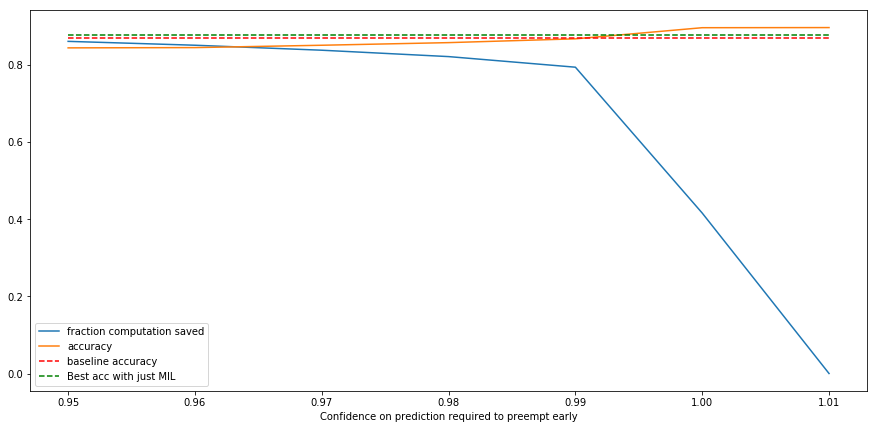

In [9]:
outputs, softmaxOut, predictions = network.inference(x_test, 1000)
trueLabels = np.argmax(y_test, axis=2)
minProbList = np.arange(0.95, 1.01, 0.01)
savingsList = []
accList = []
for minProb in minProbList:
    predictions, predictionStep = getJointPredictions(softmaxOut, earlyPolicy2, minProb=minProb)
    df = analysisModelMultiClass(predictions, trueLabels, BAG_TEST,
                                 numSubinstance=NUM_SUBINSTANCE, numClass=NUM_OUTPUT,
                                 verbose=False, redirFile=DEVNULL)
    savings = getEarlySaving(predictionStep, NUM_TIME_STEPS)
    accList.append(np.max(df.acc.values))
    savingsList.append(savings)

# These are bogus figures for illustration purposes only
baselineAcc = 0.870437
milBestAcc = 0.877564
fig = plt.figure(figsize=(15, 7))
plt.plot(minProbList, savingsList, label='fraction computation saved')
plt.plot(minProbList, accList, label='accuracy')
plt.plot(minProbList, [baselineAcc] * len(accList), 'r--', label='baseline accuracy')
plt.plot(minProbList, [milBestAcc] * len(accList), 'g--', label='Best acc with just MIL')
plt.xlabel('Confidence on prediction required to preempt early')
plt.legend()
plt.show()